In [1]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load preprocessed data
data = pd.read_csv('../data/processed_bongo_scam.csv')
print("Preprocessed data sample:")
print(data[['Category', 'cleaned_sms']].head())

/home/sj/code/iwazolab/bongo_scam_detection/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Preprocessed data sample:
  Category                                        cleaned_sms
0    trust                   nipigie baada saa moja tafadhali
1     scam  naomba unitumie iyo hela kwenye namba airtel j...
2     scam  karibu freemason utimize ndoto biashara kilimo...
3    trust               watoto wanapenda zawadi ulizowaletea
4     scam  iyo pesa itume kwenye namba jina italeta magom...


In [2]:
# Use a 10% subset for faster training
data_subset = data.sample(frac=0.1, random_state=42)

# Split data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data_subset['cleaned_sms'].tolist(),
    data_subset['Category'].map({'trust': 0, 'scam': 1}).tolist(),
    test_size=0.2,
    random_state=42
)
print(f"Training samples: {len(train_texts)}, Test samples: {len(test_texts)}")

Training samples: 120, Test samples: 31


In [3]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('Davlan/afro-xlmr-base')
model = AutoModelForSequenceClassification.from_pretrained('Davlan/afro-xlmr-base', num_labels=2)
print("AfroXLMR loaded successfully.")

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AfroXLMR loaded successfully.


In [4]:
# Tokenize with dynamic padding (max_length=50)
def tokenize_function(texts):
    return tokenizer(texts, padding='longest', truncation=True, max_length=50, return_tensors='pt')

train_encodings = tokenize_function(train_texts)
test_encodings = tokenize_function(test_texts)

In [5]:
# Create PyTorch dataset
class SwahiliDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = SwahiliDataset(train_encodings, train_labels)
test_dataset = SwahiliDataset(test_encodings, test_labels)

In [6]:
# Training arguments
training_args = TrainingArguments(
    output_dir='../results',
    num_train_epochs=1,        
    per_device_train_batch_size=8, 
    per_device_eval_batch_size=8,   
    eval_strategy='no',        
    save_strategy='no',        
    logging_steps=5,         
    logging_dir='../logs',
)

# Define metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='binary')
    return {'f1': f1}
print("Training setup complete.")

Training setup complete.


Initializing Trainer...
Trainer initialized.
Starting training...


Step,Training Loss
5,0.528400
10,0.604200
15,0.536600


Training completed.
Starting evaluation...


Evaluation completed. F1-Score: 0.7083
Generating confusion matrix...


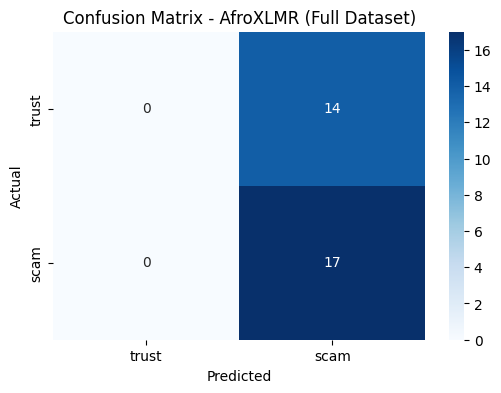

Confusion matrix plotted and saved.


In [7]:
# Trainer
print("Initializing Trainer...")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)
print("Trainer initialized.")

# Train
print("Starting training...")
trainer.train()
print("Training completed.")

# Evaluate
print("Starting evaluation...")
eval_results = trainer.evaluate()
print(f"Evaluation completed. F1-Score: {eval_results['eval_f1']:.4f}")

# Confusion Matrix
print("Generating confusion matrix...")
predictions = trainer.predict(test_dataset)
y_pred = predictions.predictions.argmax(-1)
cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['trust', 'scam'], yticklabels=['trust', 'scam'])
plt.title('Confusion Matrix - AfroXLMR (Full Dataset)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('../reports/visualizations/transformer_confusion_matrix.png')
plt.show()
print("Confusion matrix plotted and saved.")